# Basic Neural Networks 

(to compare pre-transfer learning)

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

2023-01-06 09:46:34.524862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [2]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

In [3]:
X_unseen_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_unseen.nc').to_dataframe().dropna() 
y_unseen_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_unseen.nc').to_dataframe().dropna() 

### Create Numpy Arrays for Original Data

In [44]:
X = X_df.to_numpy()         
y = y_df.to_numpy().ravel() 
X_train = X_train_df.to_numpy() 
y_train = y_train_df.to_numpy().ravel()
X_test = X_test_df.to_numpy()  
y_test = y_test_df.to_numpy().ravel()

## Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

In [4]:
X_df_norm = (X_df - X_df.mean())/X_df.std() 
y_df_norm = (y_df - y_df.mean())/y_df.std()
X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

### Create Numpy Arrays for Normalized Data

In [5]:
X_n = X_df_norm.to_numpy()         
y_n = y_df_norm.to_numpy().ravel() 
X_train_n = X_train_df_norm.to_numpy()
y_train_n = y_train_df_norm.to_numpy().ravel()
X_test_n = X_test_df_norm.to_numpy() 
y_test_n = y_test_df_norm.to_numpy().ravel()

# Preliminary NN Model

## Build NN Model

In [ ]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [18]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [19]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model.add(Dense(y_train_df.shape[1],  activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [20]:
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                704       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 1942.4406 - val_loss: 851.7762
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 752.4636 - val_loss: 816.1976
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 693.0726 - val_loss: 710.0928
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 652.3337 - val_loss: 761.5913
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 616.1006 - val_loss: 666.7382
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 591.7091 - val_loss: 595.8848
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 559.5195 - val_loss: 600.5497
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 515.2448 - val_loss: 538.8752
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 472.9017 - val_loss: 547.7735
Epoch 10/50
2483/2483 [======================

*Can see that validation loss reaches a minimum and then starts rising through epochs, indicating overfitting*

## Save NN Model

In [23]:
# after training, save:
model_path = '/home/julias/MLEE-final-project/models/saved_models'
NN_model.save(os.path.join(model_path,'NN_model_preliminary_rerun.h5'))

## Test NN Model

In [24]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(model_path,'NN_model_preliminary_rerun.h5'))

In [25]:
y_pred = NN_prelim_model.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 740us/step
MSE: 238.50


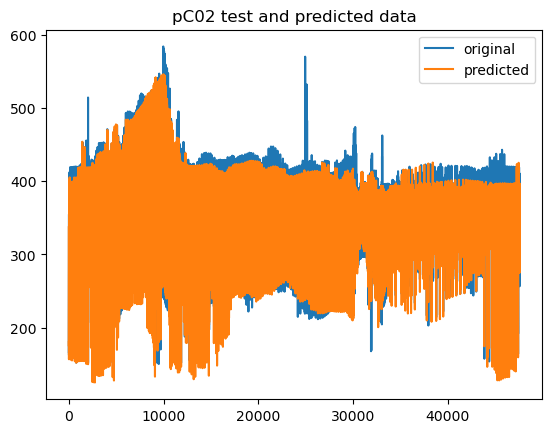

In [26]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# Build and Train a Preliminary NN Model using Numpy as Input

## Build NN Model

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [33]:
y_train.shape

(198577,)

In [36]:
NN_model_nprelim = Sequential()

NN_model_nprelim.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nprelim.add(Dense(1,  activation='linear')) # the output layer


NN_model_nprelim.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [37]:
NN_model_nprelim.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                704       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nprelim = NN_model_nprelim.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 2185.3374 - val_loss: 827.7376
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 810.8165 - val_loss: 707.8122
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 702.8127 - val_loss: 849.1256
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 645.5285 - val_loss: 603.4423
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 603.9830 - val_loss: 536.4496
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 572.2943 - val_loss: 536.2884
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 533.5015 - val_loss: 545.0120
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 489.9393 - val_loss: 438.8030
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 450.7432 - val_loss: 434.4235
Epoch 10/50
2483/2483 [======================

## Save NN Model

In [39]:
# after training, save:
model_path = '/home/julias/MLEE-final-project/models/saved_models'
NN_model_nprelim.save(os.path.join(model_path,'NN_model_preliminary_numpyinput_rerun.h5'))

## Test NN Model

In [40]:
NN_model_num_prelim_rerun = load_model(os.path.join(model_path,'NN_model_preliminary_numpyinput.h5'))

In [41]:
y_pred_nprelim_rerun = NN_model_num_prelim_rerun.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nprelim_rerun)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 708us/step
MSE: 250.06


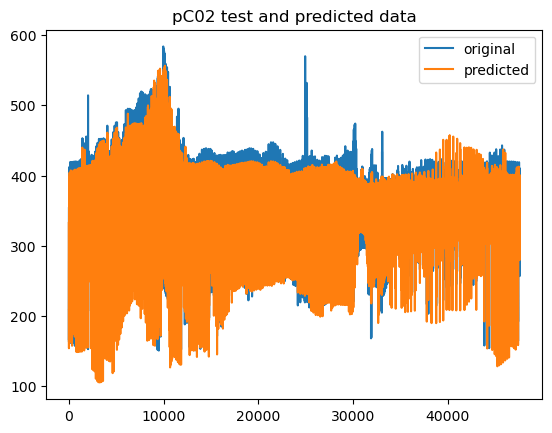

In [43]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_nprelim_rerun, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# Select Approach & Parameters

## Approach

- Based on preliminary experimentation, will train the NN model on ___ data

## Parameters

- Based on preliminary experimentation, will design a NN with the below hyperparameters

# Five Identical NN Models 

## NN Model 1

## NN Model 2

## NN Model 3

## NN Model 4

## NN Model 5